In [50]:
import os
import matplotlib.gridspec as gridspec
import matplotlib.image as img
import matplotlib.pyplot as plt

import numpy as np
import cv2

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from moviepy.editor import VideoFileClip


class DataProvider():
    def __init__(self):
        self.cars=None
        

    def deserialize(self,path, fext='.png'):
        fnames = []
        #print(parent)
        for root, dirs, files in os.walk(path):
            for f in files:
                if f.endswith(fext):
                    fnames.append(os.path.join(root, f))
        return fnames
    
    def gridOfrandomimages(self,fnames, rows=6,cols=6,title=None):
        nbimages = rows*cols
        #print(nbimages)
        rndfnames = np.random.choice(fnames,nbimages )
        images = []
        for fname in rndfnames:
            images.append(img.imread(fname))

        grid_space = gridspec.GridSpec(cols, rows)
        grid_space.update(wspace=0.1, hspace=0.1)
        plt.figure(figsize=(rows, cols))

        for idx in range(0, nbimages):
            axis_1 = plt.subplot(grid_space[idx])
            axis_1.axis('off')
            axis_1.imshow(images[idx])

        if title is not None:
            plt.suptitle(title)
        plt.show()
        
        
    @staticmethod
    def files(path,fext='.png', show=True):
        dt = DataProvider()
        fnames = dt.deserialize(path,fext)
        if show :
            dt.gridOfrandomimages(fnames)
        return fnames

    @staticmethod
    def visualize(fnames):
        dt = DataProvider()
        dt.gridOfrandomimages(fnames)
    

In [51]:
import cv2
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog


class FeaturesExtractor():
    def __init__(self):
        pass
        
    def hogfeatures(self, image, orient, pix_per_cell, cell_per_block, show=False, feature_vec=True):
    
        if show:
            features, hog_image = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, \
                                      visualise=True, feature_vector=False)
            return features.ravel(), hog_image
        else:

            features = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, \
                           visualise=False, feature_vector=feature_vec)
            return features.ravel()
        
    def binspatial(self, image, size=(32, 32)):
    
        color1 = cv2.resize(image[:, :, 0], size).ravel()
        color2 = cv2.resize(image[:, :, 1], size).ravel()
        color3 = cv2.resize(image[:, :, 2], size).ravel()
        return np.hstack((color1, color2, color3))


    def histogramcolor(self, img, nbins=32):
      
        color_1_hist = np.histogram(img[:, :, 0], bins=nbins)
        color_2_hist = np.histogram(img[:, :, 0], bins=nbins)
        color_3_hist = np.histogram(img[:, :, 0], bins=nbins)
        return np.concatenate((color_1_hist[0], color_2_hist[0], color_3_hist[0]))


    def extract_features(self, images, cspace='RGB', orient=9, spatial_size=(32, 32), hist_bins=32,
                     pix_per_cell=8, cell_per_block=2,
                     spatial_feat=True, hist_feat=True, hog_feat=True, hog_channel=0):
    
        features = []
        # Iterate through the list of images
        for image in images:
            ffeatures = []
            if cspace != 'RGB':
                if cspace == 'HSV':
                    ftimage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    ftimage = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    ftimage = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    ftimage = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif cspace == 'YCrCb':
                    ftimage = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else:
                ftimage = np.copy(image)

            if spatial_feat:
                spatial_features = self.binspatial(ftimage, size=spatial_size)
                ffeatures.append(spatial_features)
            if hist_feat:
                hist_features = self.histogramcolor(ftimage, nbins=hist_bins)
                ffeatures.append(hist_features)

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(ftimage.shape[2]):
                    hog_features.append(self.hogfeatures(ftimage[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         show=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
                ffeatures.append(hog_features)
            else:
                hog_features = self.hogfeatures(ftimage[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, show=False, feature_vec=True)
                ffeatures.append(hog_features)

            features.append(np.concatenate(ffeatures))
        return np.array(features)
    
    def single_img_features(self, img, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True, show=False):    
        #1) Define an empty list to receive features
        img_features = []
        show_images = []
        #2) Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      
        show_images.append(img[:,:,0])
        show_images.append(img[:,:,1])
        show_images.append(img[:,:,2])
        
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = self.binspatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = self.histogramcolor(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(self.hogfeatures(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        show=False, feature_vec=True))      
            else:
                hog_features, img_hog = self.hogfeatures(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, show=True, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
            show_images.append(img_hog)
        
        if show :
            self.visualize(show_images)

        #9) Return concatenated array of features
        return np.concatenate(img_features)
    
    def visualize(self,images, rows=6,cols=6,title=None):
        nbimages = len(images)
        #print(nbimages)
       
        grid_space = gridspec.GridSpec(cols, rows)
        grid_space.update(wspace=0.1, hspace=0.1)
        plt.figure(figsize=(20, 20))

        for idx in range(0, nbimages):
            axis_1 = plt.subplot(grid_space[idx])
            axis_1.axis('off')
            #image = cv2.resize(images[idx], (100, 100))
            image = images[idx]
            axis_1.imshow(image)

        if title is not None:
            plt.suptitle(title)
        plt.show()
        
    @staticmethod
    def gethogfeatures(show=False):
        veh_fnames = DataProvider.files('./vehicles',show=False)
        nveh_fnames = DataProvider.files('./non-vehicles', show=False)
        image = img.imread(veh_fnames[0])
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Define HOG parameters
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        # Call our function with vis=True to see an image output
        fte = FeaturesExtractor()
        features, hog_image = fte.hogfeatures(gray, orient, pix_per_cell, cell_per_block, show=True, feature_vec=False)
        if show :
            print(hog_image.shape)
            fte.visualize([image,hog_image])
            
        return features, hog_image
    
    
    @staticmethod
    def show_featuresOfrndimage():
        fte = FeaturesExtractor()
        veh_fnames = DataProvider.files('./vehicles',show=False)
        nveh_fnames = DataProvider.files('./non-vehicles', show=False)
        image = img.imread(veh_fnames[0])
        fte.single_img_features(image, color_space='YCrCb', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True, show=True)
        
        image = img.imread(nveh_fnames[0])
        fte.single_img_features(image, color_space='YCrCb', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True, show=True)

class Windows():
    def __init__(self):
        self.fte = FeaturesExtractor()
    
    
    def slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None],\
                             xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] is None:
            x_start_stop[0] = 0
        if x_start_stop[1] is None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] is None:
            y_start_stop[0] = 0
        if y_start_stop[1] is None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_windows = np.int(xspan / nx_pix_per_step) - 1
        ny_windows = np.int(yspan / ny_pix_per_step) - 1
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs * nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys * ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list
    
    def search_windows(self, img, windows, clf, scaler, color_space,
                   spatial_size, hist_bins,
                   orient, pix_per_cell, cell_per_block,
                   hog_channel, spatial_feat,
                   hist_feat, hog_feat):
    
        on_windows = []
        for window in windows:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            extracted_features = self.fte.extract_features([test_img], cspace=color_space, orient=orient, spatial_size=spatial_size,
                                                  hist_bins=hist_bins,
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                  spatial_feat=spatial_feat, hist_feat=hog_feat, hog_feat=hist_feat,
                                                  hog_channel=hog_channel)

            test_features = scaler.transform(np.array(extracted_features).reshape(1, -1))
            prediction = clf.predict(test_features)

            if prediction == 1:
                on_windows.append(window)
        return on_windows
    
    # Define a function to draw bounding boxes
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy
    
    def add_heat(self,heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap


    def draw_sliding_windows(self,image, windows, color=(197, 27, 138), thick=3):
       
        for window in windows:
            cv2.rectangle(image, window[0], window[1], color, thick)
        return image

    def apply_threshold(self,heatmap, threshold):
       
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap


    def draw_labeled_bboxes(self, img, labels):
       
        # Iterate through all detected cars
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (197, 27, 138), 3)
        # Return the image
        return img

class FrameQueue:
    def __init__(self, max_frames):
        self.frames = []
        self.max_frames = max_frames

    def enqueue(self, frame):
        self.frames.insert(0, frame)

    def _size(self):
        return len(self.frames)

    def _dequeue(self):
        num_element_before = len(self.frames)
        self.frames.pop()
        num_element_after = len(self.frames)

        assert num_element_before == (num_element_after + 1)

    def sum_frames(self):
        if self._size() > self.max_frames:
            self._dequeue()
        all_frames = np.array(self.frames)
        return np.sum(all_frames, axis=0)
    
class Vehicle:
    

    def __init__(self, color_space, orient, pix_per_cell, cell_per_block,
                 hog_channel, spatial_size, hist_bins, spatial_feat,
                 hist_feat, hog_feat, y_start_stop, x_start_stop, xy_window,
                 xy_overlap, heat_threshold, scaler, classifier):
        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.y_start_stop = y_start_stop
        self.x_start_stop = x_start_stop
        self.xy_window = xy_window
        self.xy_overlap = xy_overlap
        self.heat_threshold = heat_threshold
        self.scaler = scaler
        self.classifier = classifier
        self.win = Windows()
        self.frame_queue = FrameQueue(25)

    def detect(self, input_image):
        copy_image = np.copy(input_image)
        copy_image = copy_image.astype(np.float32) / 255

        slided_windows = self.win.slide_window(copy_image, x_start_stop=self.x_start_stop,
                                      y_start_stop=self.y_start_stop,
                                      xy_window=self.xy_window, xy_overlap=self.xy_overlap)

        on_windows = self.win.search_windows(copy_image, slided_windows, self.classifier, self.scaler,
                                    color_space=self.color_space, spatial_size=self.spatial_size,
                                    hist_bins=self.hist_bins, orient=self.orient,
                                    pix_per_cell=self.pix_per_cell, cell_per_block=self.cell_per_block,
                                    hog_channel=self.hog_channel, spatial_feat=self.spatial_feat,
                                    hist_feat=self.hist_feat, hog_feat=self.hog_feat)

        heat_map = np.zeros_like(copy_image)
        heat_map = self.win.add_heat(heat_map, on_windows)
        self.frame_queue.enqueue(heat_map)

        all_frames = self.frame_queue.sum_frames()
        heat_map = self.win.apply_threshold(all_frames, self.heat_threshold)

        labels = label(heat_map)

        image_with_bb = self.win.draw_labeled_bboxes(input_image, labels)
        return image_with_bb
    
    @staticmethod
    def run(video=True):
        veh_fnames = DataProvider.files('./vehicles')
        nveh_fnames = DataProvider.files('./non-vehicles')
        vehimages = [img.imread(f) for f in veh_fnames]
        nvehimages = [img.imread(f) for f in nveh_fnames]
        # Define HOG parameters
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        # Call our function with vis=True to see an image output
        fte = FeaturesExtractor()
        color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
        spatial_size = (32, 32)  # Spatial binning dimensions
        hist_bins = 32  # Number of histogram bins
        spatial_feat = True  # Spatial features on or off
        hist_feat = True  # Histogram features on or off
        hog_feat = True  # HOG features on or off
        x_start_stop=[None, None]
        y_start_stop = [400,600]
        xy_window=(96, 85)
        xy_overlap=(0.75, 0.75)

        C_values = [0.08, 0.2, 0.4, 0.8, 1.0, 1.2, 1.4, 1.8, 2.6]
        penalties = ['l2']
        losses = ['hinge', 'squared_hinge']

        training_accuracies = []
        validation_accuracies = []
        best_c = 1.0
        best_penalty = 'l2'
        best_loss = 'hinge'

        best_accuracy = 0.0

        vfeatures = fte.extract_features(vehimages, color_space, orient, spatial_size, hist_bins,\
                                                    pix_per_cell, cell_per_block, spatial_feat, hist_feat, hog_feat,\
                                                    hog_channel)
        
        print('vehicle features dimensions: {}'.format(vfeatures.shape))

        nvfeatures = fte.extract_features(nvehimages, color_space, orient, spatial_size,\
                                                        hist_bins, pix_per_cell, cell_per_block, spatial_feat,\
                                                        hist_feat, hog_feat, hog_channel)
        
        print('non-vehicle features dimensions: {}'.format(nvfeatures.shape))

        X_features = np.vstack((vfeatures, nvfeatures)).astype(np.float64)
        print('Dataset dimensions: {}'.format(vfeatures.shape))

        y_features = np.hstack((np.ones(len(vehimages)), np.zeros(len(nvehimages))))
        
        for c in C_values:
            for penalty in penalties:
                for loss in losses:
                    X_train, X_test, y_train, y_test = train_test_split(X_features, y_features,
                                                                        test_size=0.3, random_state=2048)

                    scaler = StandardScaler().fit(X_train)

                    X_train = scaler.transform(X_train)
                    X_test = scaler.transform(X_test)

                    svc = LinearSVC(C=c, penalty=penalty, loss=loss).fit(X_train, y_train)
                    accuracy = svc.score(X_test, y_test)
                    print('Validation accuracy: {:.4f} with C: {}, panelty: {}, loss: {}'.format(
                        accuracy, c, penalty, loss))

                    if best_accuracy < accuracy:
                        best_accuracy = accuracy
                        best_c = c
                        best_loss = loss
                        best_penalty = penalty

                    validation_accuracies.append(accuracy)
                    training_accuracies.append(svc.score(X_train, y_train))

        print('Best validation accuracy: {:.4f}'.format(best_accuracy))
        print('Best parameters: C: {}, penalty: {}, loss: {}'.format(best_c, best_penalty, best_loss))

        print('')
        print('Best hyper-parameters')
        
        scaler = StandardScaler().fit(X_features)
        X_features = scaler.transform(X_features)
        svc = LinearSVC(C=best_c, penalty=best_penalty, loss=best_loss).fit(X_features, y_features)

        vehicle = Vehicle(color_space=color_space,
                                          orient=orient,
                                          pix_per_cell=pix_per_cell,
                                          cell_per_block=cell_per_block,
                                          hog_channel=hog_channel,
                                          spatial_size=spatial_size,
                                          hist_bins=hist_bins,
                                          spatial_feat=spatial_feat,
                                          hist_feat=hist_feat,
                                          hog_feat=hog_feat,
                                          y_start_stop=y_start_stop,
                                          x_start_stop=x_start_stop,
                                          xy_window=xy_window,
                                          xy_overlap=xy_overlap,
                                          heat_threshold = 15,
                                          scaler=scaler,
                                          classifier=svc)
        if video :
            output_file = './processed_project_video.mp4'
            input_file = './project_video.mp4'
            clip = VideoFileClip(input_file)
            out_clip = clip.fl_image(vehicle.detect)
            out_clip.write_videofile(output_file, audio=False)
        else:
            imgs = ['test1.jpg','test2.jpg','test3.jpg','test4.jpg',\
                    'test5.jpg','test6.jpg']
            for fname in imgs:
                imag = cv2.imread('./test_images/'+fname)
                imag = vehicle.detect(imag)
                cv2.imwrite('./output_images/'+fname,imag)
       
        




In [52]:
#features, hog_image = FeaturesExtractor.gethogfeatures(show=True)
#FeaturesExtractor.show_featuresOfrndimage()



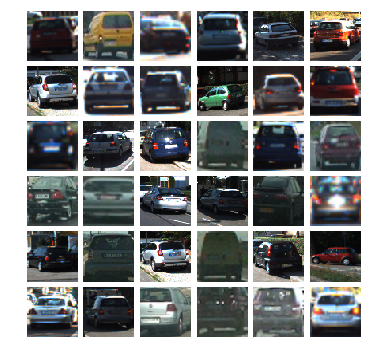

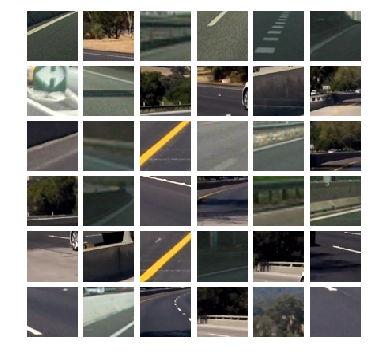

Shape of the vehicle features: (8792, 8460)
Shape of the non-vehicle features: (8968, 8460)
Shape of the entire dataset: (8792, 8460)
Validation accuracy: 0.9880 with C: 0.08, panelty: l2, loss: hinge
Validation accuracy: 0.9880 with C: 0.08, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9880 with C: 0.2, panelty: l2, loss: hinge
Validation accuracy: 0.9880 with C: 0.2, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9880 with C: 0.4, panelty: l2, loss: hinge
Validation accuracy: 0.9880 with C: 0.4, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9880 with C: 0.8, panelty: l2, loss: hinge
Validation accuracy: 0.9880 with C: 0.8, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9880 with C: 1.0, panelty: l2, loss: hinge
Validation accuracy: 0.9880 with C: 1.0, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9880 with C: 1.2, panelty: l2, loss: hinge
Validation accuracy: 0.9880 with C: 1.2, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9

In [53]:
#Vehicle.run()
Vehicle.run(video=False)